# SHAP values analysis

## Rationale:
SHAP (SHapley Additive exPlanations) values are a popular method for explaining the predictions of machine learning models. Here's a brief summary of the rationale behind using SHAP values for model explainability:


1. Consistency and Fairness: SHAP values offer a consistent and mathematically grounded way to attribute contributions of features to predictions. This can help in ensuring fairness and transparency in models, as decisions can be explained based on feature contributions.
2. Global and Local Interpretability: SHAP values offer both global and local interpretability. You can analyze feature importance globally to understand which features are generally important for the model. At the same time, you can explain the impact of each feature for a particular prediction, providing local interpretability.
3. Model-Agnostic: SHAP values are model-agnostic, which means they can be applied to any machine learning model, whether it's a linear model, decision tree, deep neural network, or any other. This flexibility is essential in practice, where various models may be used for different tasks.


## Methodology:
We are to use the predict function to calulate the predictions on the test set and then calculate the SHAP vaues by feature and group of features.


## Conclusions:

By far, the most impactful features for the model are the inner models that were created from the individual datasources. It indicates that this approach was able to condense most of the information on each source and thus, the model was able to capture high amount of information with a reduced set of features.

Regarding to the importance by comany type we do not se any difference in the order among the risk bands, so the most relevant features are also important across this subpopulation.

Regaring to the most relevant sources of data we can list them from the most important to the least:

1. Main application
2. Installment
3. Credit bureau
4. POS
5. Previous application
6. Credit card

This is alligned with my experience since the main application info contains also external scores probably the FICO score.

In [84]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")


import joblib

import shap
from sklearn.metrics import roc_auc_score


import warnings;warnings.filterwarnings("ignore")
import sys
sys.path.append("../")

# local imports
from src.learner_params import target_column, space_column, MODEL_PARAMS
from utils.functions__training import model_pipeline
from utils.feature_selection_lists import boruta_features
from utils.functions__plotting import plot_shap

import seaborn as sns

model_path = "../model_files/boruta_learner.pkl"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
train_df = pd.read_pickle("../data/train_df.pkl")
validation_df = pd.read_pickle("../data/validation_df.pkl")
test_df= pd.read_pickle("../data/test_df.pkl")

predict_fn = joblib.load(model_path)
new_df = predict_fn["predict_fn"](test_df, apply_shap=True)
new_df.loc[:,"risk_band"] =pd.qcut(new_df.prediction, q = 5, labels=list("ABCDE"))

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


### SHAP values full population

We are to estimate the individual contribution by features on the full population

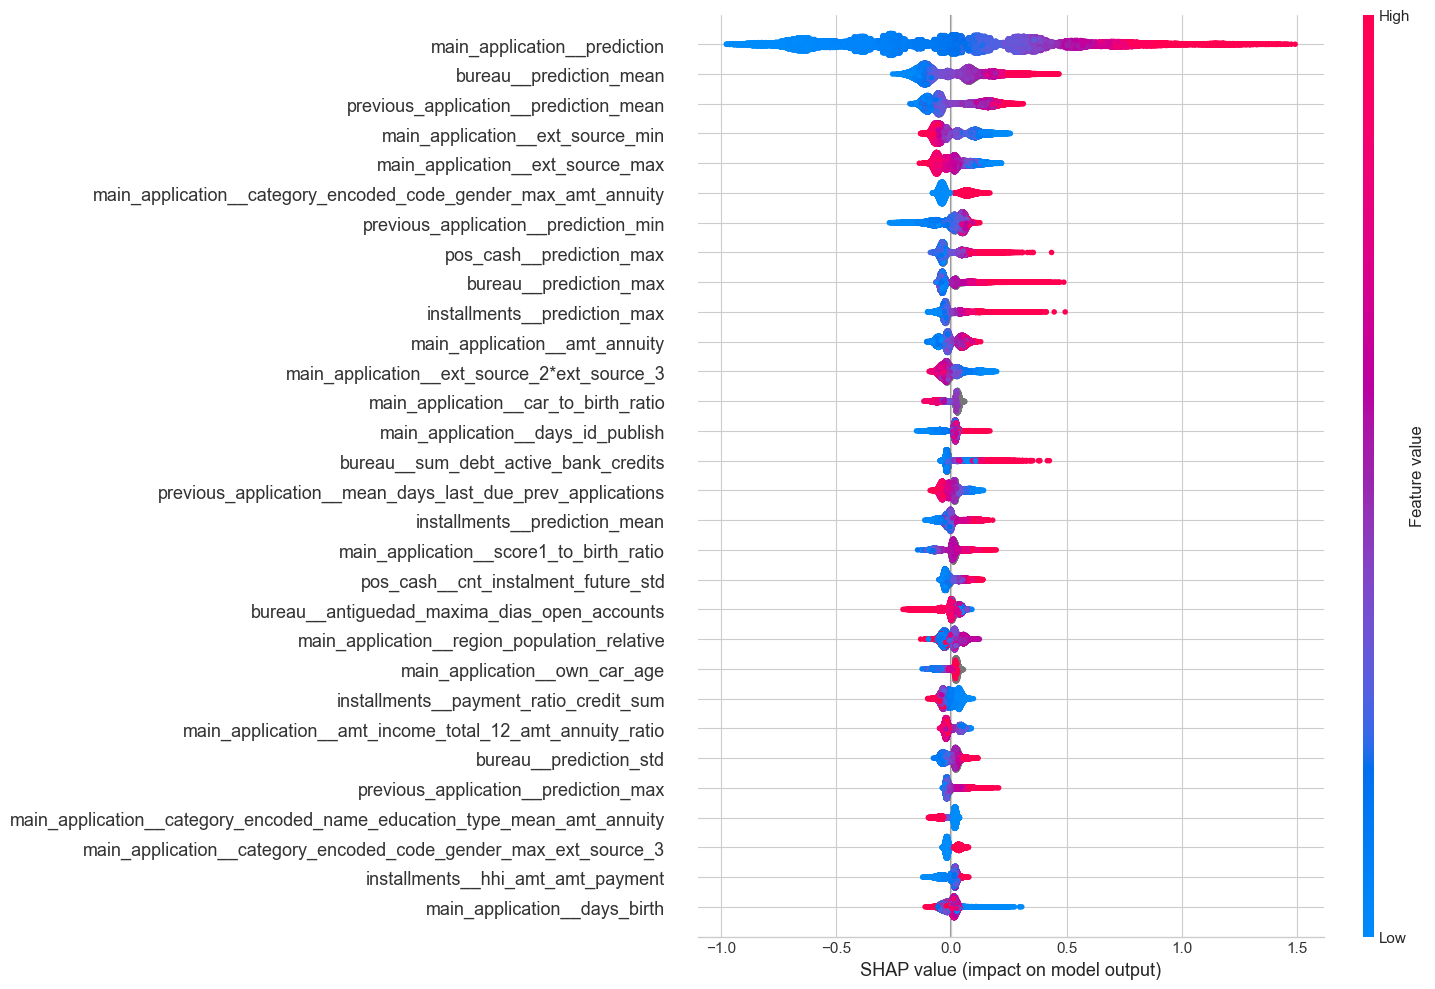

In [85]:

plot_shap(new_df, boruta_features)

### SHAP by risk band

The feature's impact will be estimated but the different subpopulations i.e risk bands from the lowest to the highest risk customers.

SHAP for risk band: A



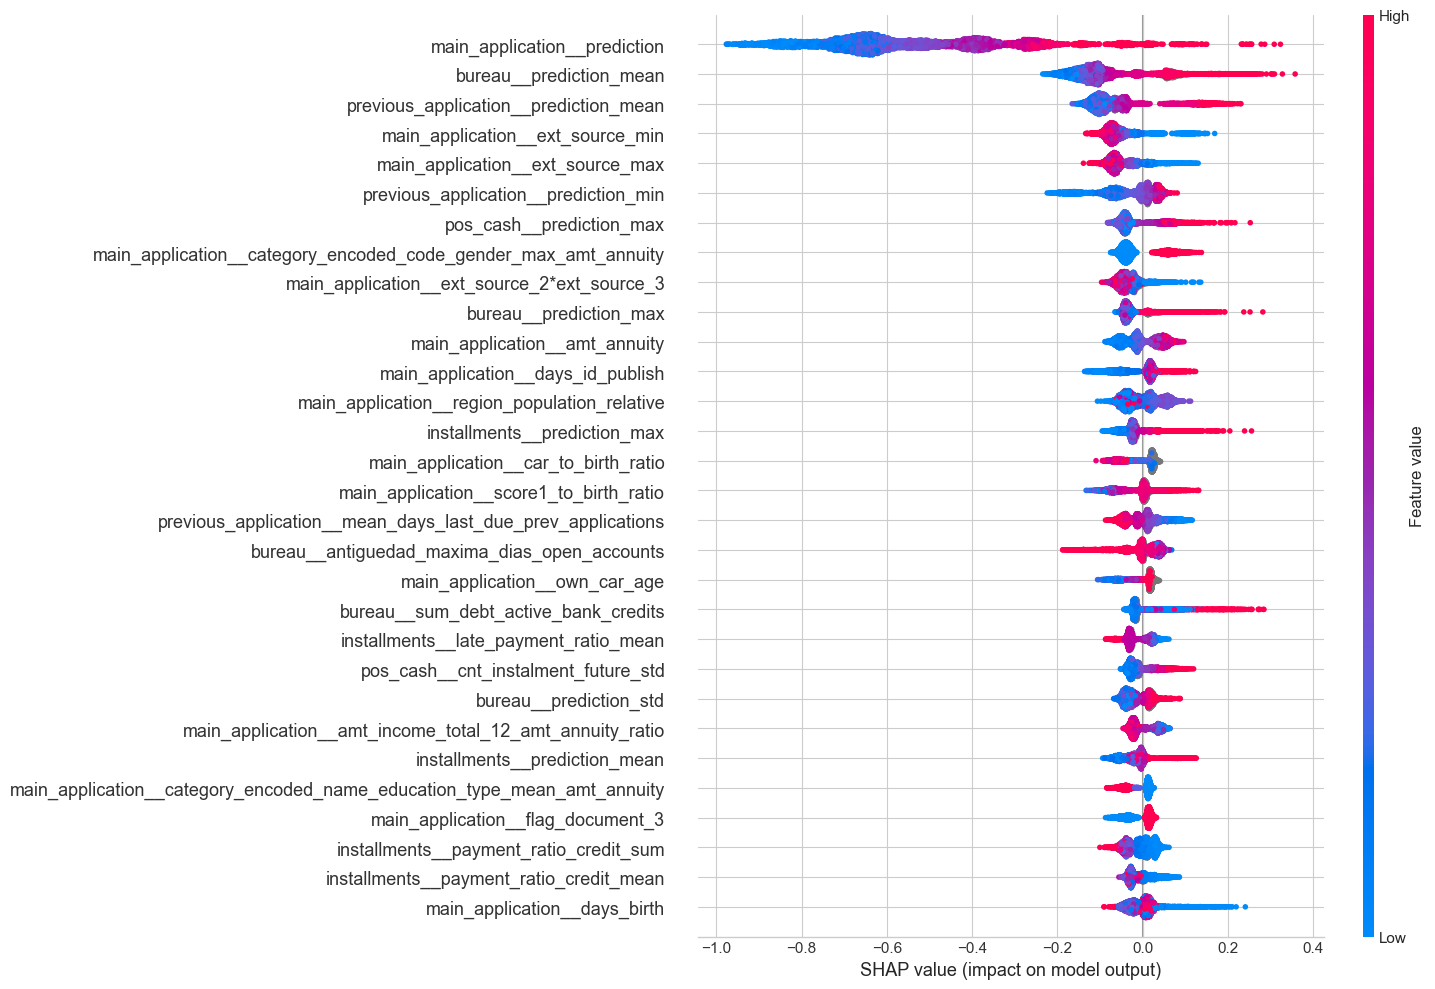

SHAP for risk band: B



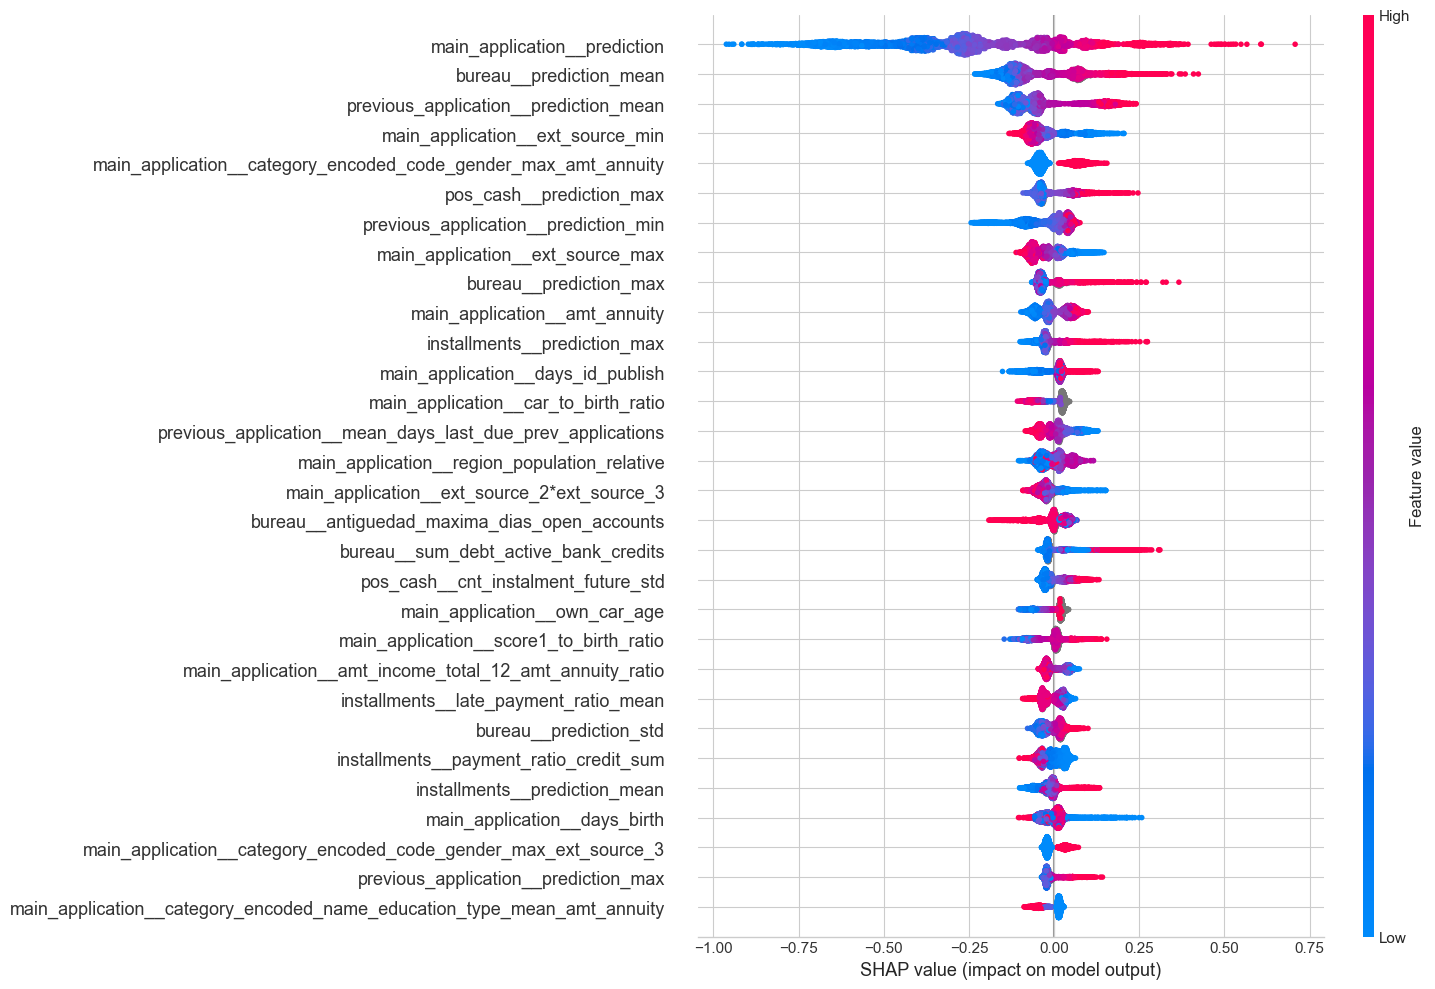

SHAP for risk band: C



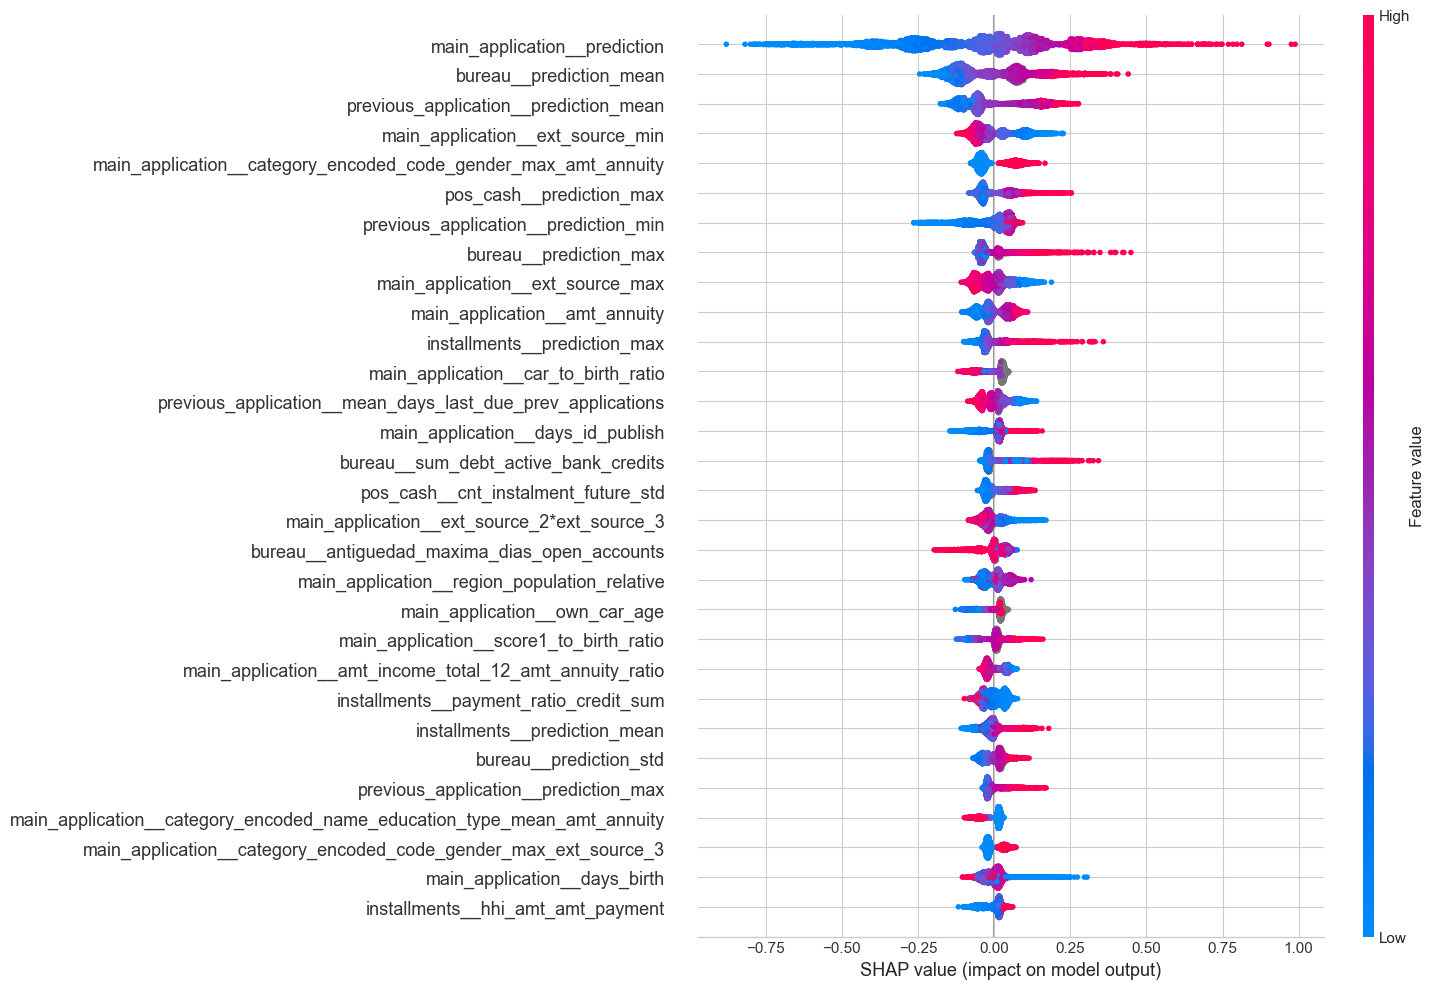

SHAP for risk band: D



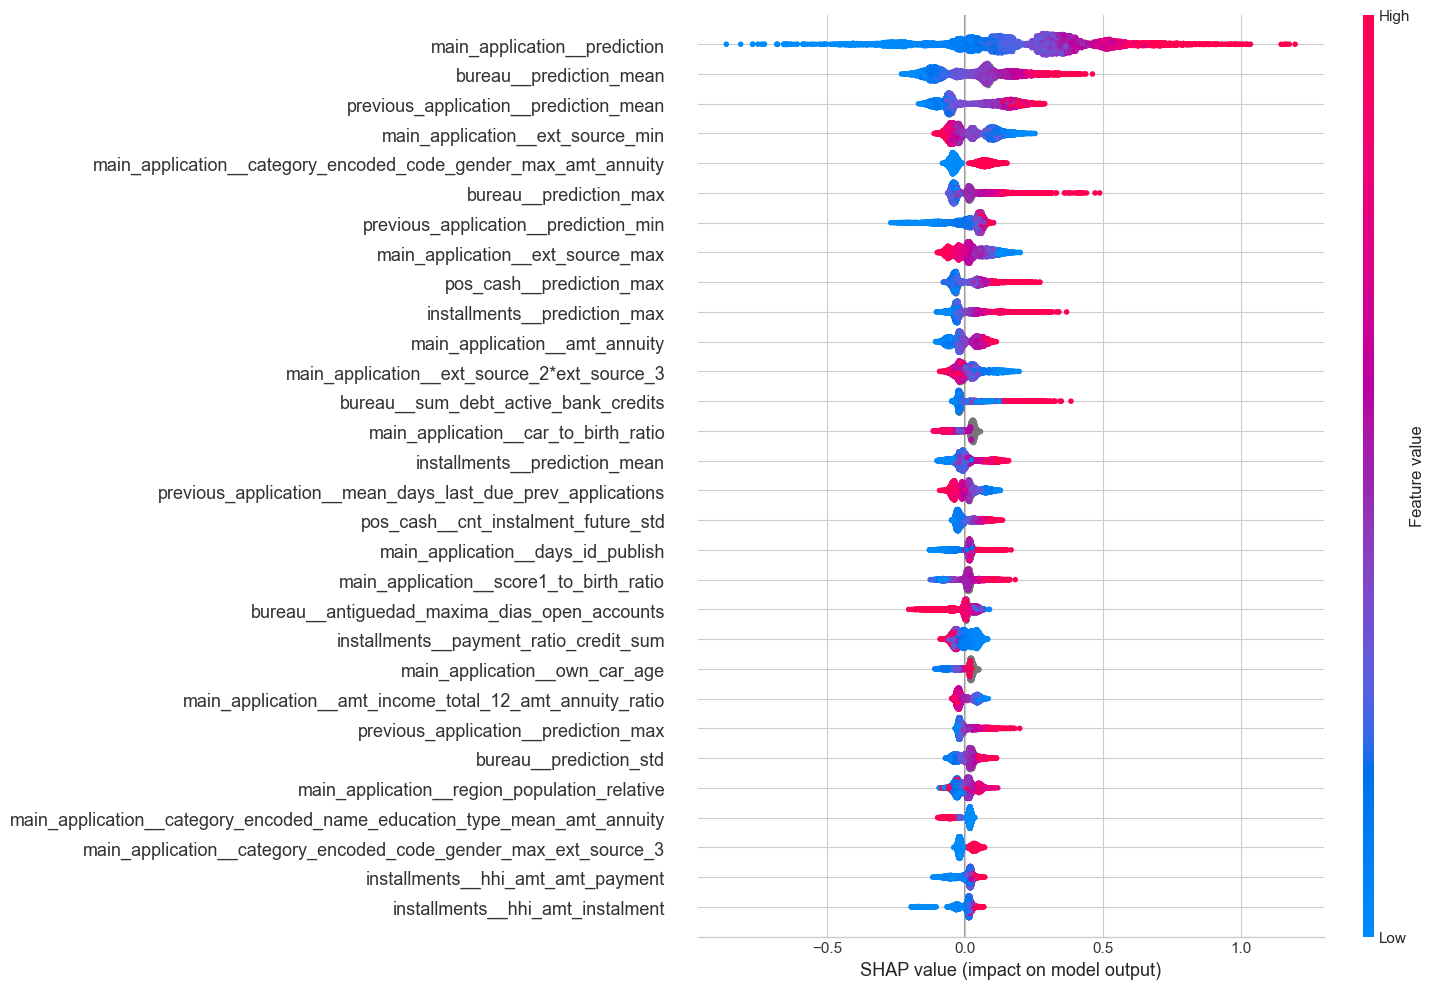

SHAP for risk band: E



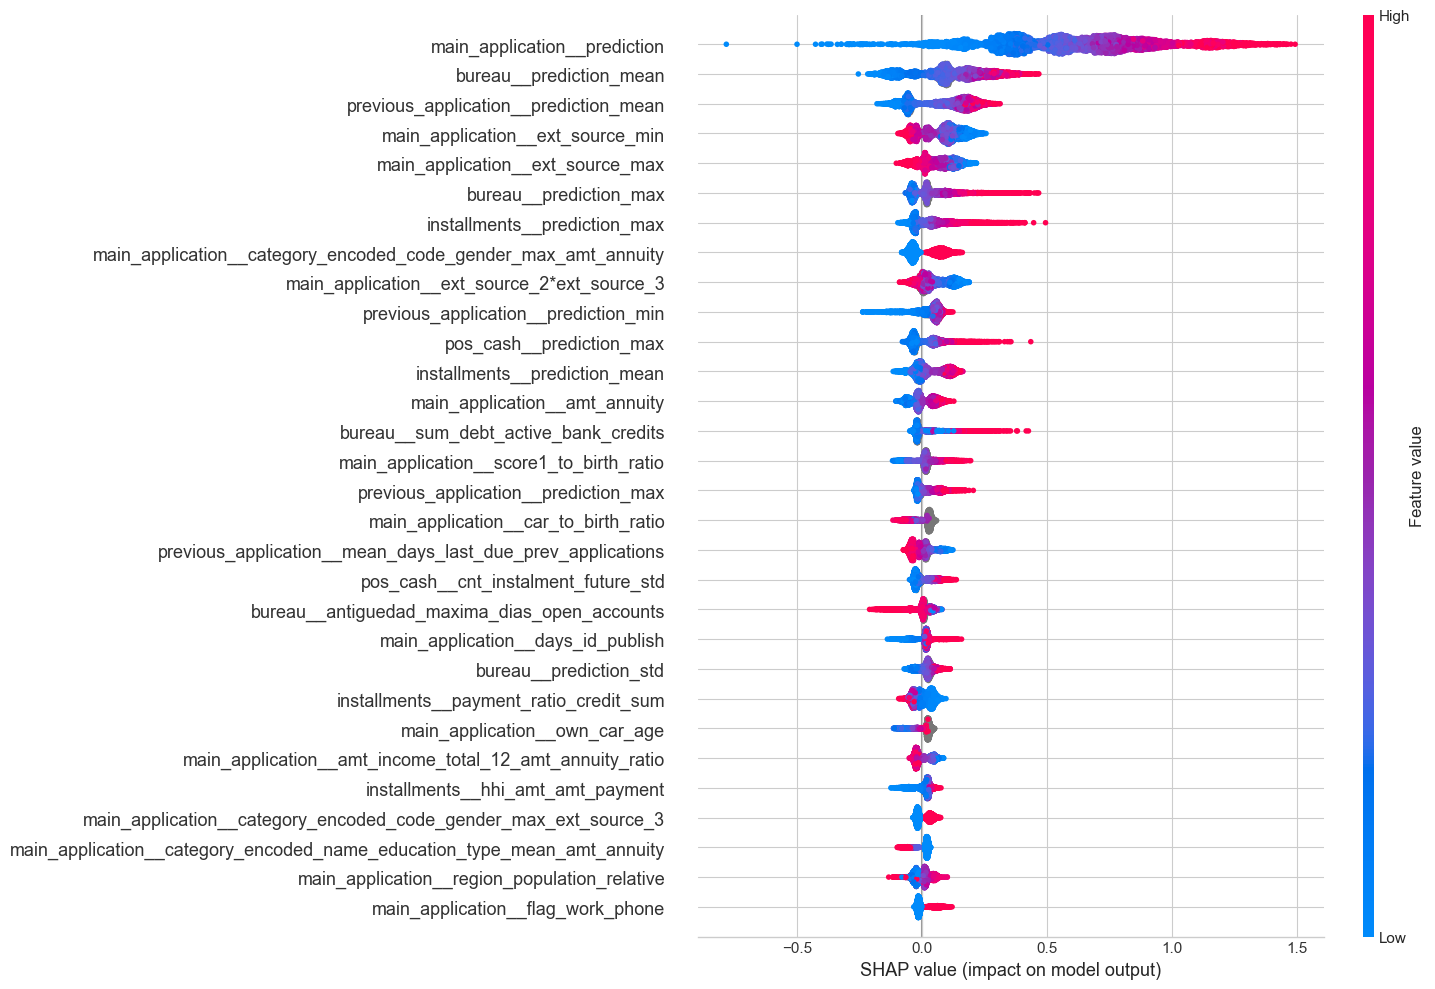

In [86]:

for cat in sorted(new_df.risk_band.unique()):
    aux = new_df[new_df.risk_band.isin([cat])]
    print(f"SHAP for risk band: {cat}\n")
    plot_shap(aux, boruta_features)

### SHAP by data source

By taking advantage of the additive property of SHAP values, we can calculate the average contribution by subset of features. In this case we are to focus on the different data sources that were used to create the input features.

In [57]:

bureau_subset_list = [x for x in boruta_features if x.startswith("bureau__")]
cc_subset_list = [x for x in boruta_features if x.startswith("credit_card__")]
install_subset_list = [x for x in boruta_features if x.startswith("installments__")]
pos_subset_list = [x for x in boruta_features if x.startswith("pos_cash__")]
prevapp_subset_list = [x for x in boruta_features if x.startswith("previous_application__")]
mainapp_subset_list = [x for x in boruta_features if x.startswith("main_application__")]

assert len(boruta_features) == len(bureau_subset_list +
                                   cc_subset_list + 
                                   install_subset_list +
                                   pos_subset_list +
                                   prevapp_subset_list +
                                   mainapp_subset_list
                                  )

avg_shap_df = pd.DataFrame(np.abs(np.vstack(new_df.shap_values)).mean(axis = 0), index = boruta_features, columns = ["avg_shap"])

In [63]:

condlist = [avg_shap_df.index.isin(bureau_subset_list), 
           avg_shap_df.index.isin(cc_subset_list),
           avg_shap_df.index.isin(install_subset_list),
           avg_shap_df.index.isin(mainapp_subset_list),
           avg_shap_df.index.isin(pos_subset_list),
           avg_shap_df.index.isin(prevapp_subset_list),]

choicelist = ['bureau',
              'credit_card',
              'installments',
              'main_application',
              'pos_cash',
              'previous_application']

avg_shap_df["feature_group"] = np.select(condlist, choicelist)

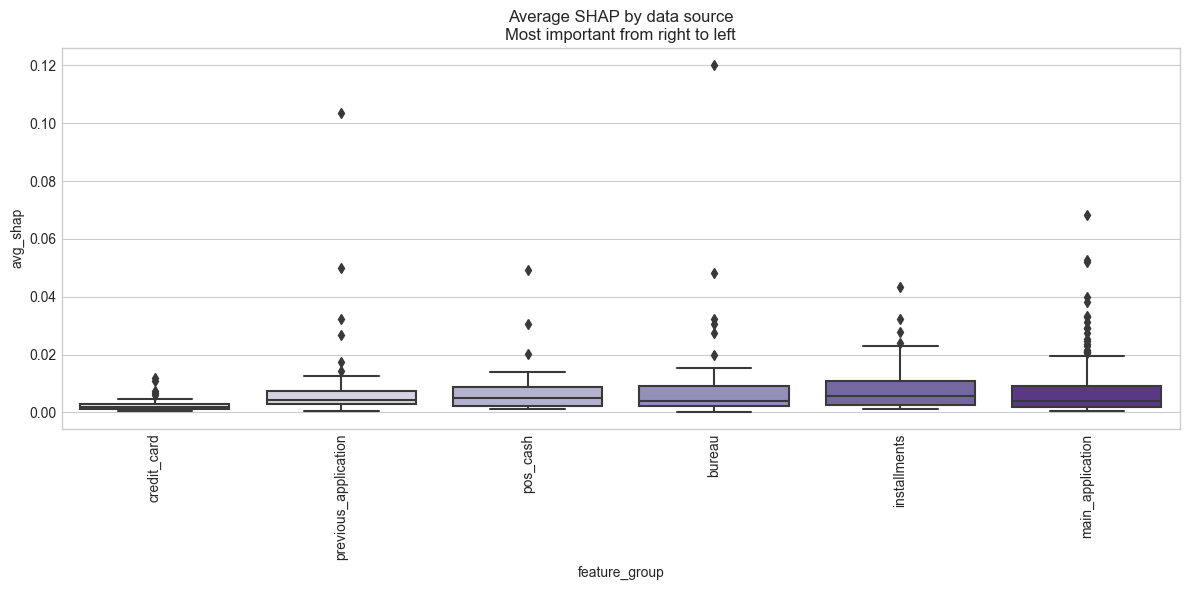

In [106]:
fig, ax = plt.subplots(figsize = (12,6))
order = avg_shap_df.groupby("feature_group").avg_shap.mean().sort_values().index.tolist()
ax = sns.boxplot(avg_shap_df.sort_values(by = "avg_shap").iloc[:-1],
            x = "feature_group",
            y = "avg_shap", order=order,palette = "Purples")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title(f"Average SHAP by data source\nMost important from right to left")
plt.tight_layout();